# Utility measures for synthetic data before and after the anonymization algorithm is applied.

In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

In [3]:
train_data = pd.read_csv("Data/cleaned_ipums_data.csv")

In [4]:
holdout_data = [pd.read_csv("Data/holdout_" + str(i) + ".csv") for i in range(20)]

In [6]:
sXs_mnl_pmse = [pd.read_csv("Data/synthetic_datasets/logistic_optimizer_logistic_pmse_ipums_" + str(i) + ".csv") for i in range(20)]

In [7]:
sXs_cart_pmse = [pd.read_csv("Data/synthetic_datasets/cart_optimizer_logistic_pmse_ipums_" + str(i) + ".csv") for i in range(20)]

In [8]:
sXs_mostly = [pd.read_csv("Data/synthetic_datasets/cleaned_ipums_data_" + str(i) + ".csv") for i in range(10)]

***

## Utility Measure 1 - pMSE Ratios

In [9]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
    
    full_X = poly.fit_transform(full_X)

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty=None, max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

In [10]:
np.mean([pmse_ratio(train_data, x) for x in holdout_data])

0.3774115716413513

In [11]:
ratios_mnl_pmse = [pmse_ratio(train_data, Y) for Y in sXs_mnl_pmse]
print(np.mean(ratios_mnl_pmse))

1.0526487568024614


In [13]:
ratios_cart_mb_pmse = [pmse_ratio(train_data, Y) for Y in sXs_cart_pmse]
print(np.mean(ratios_cart_mb_pmse))

1.6621647950739884


In [14]:
ratios_mostly = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
np.mean(ratios_mostly)

55.17653475847603

***

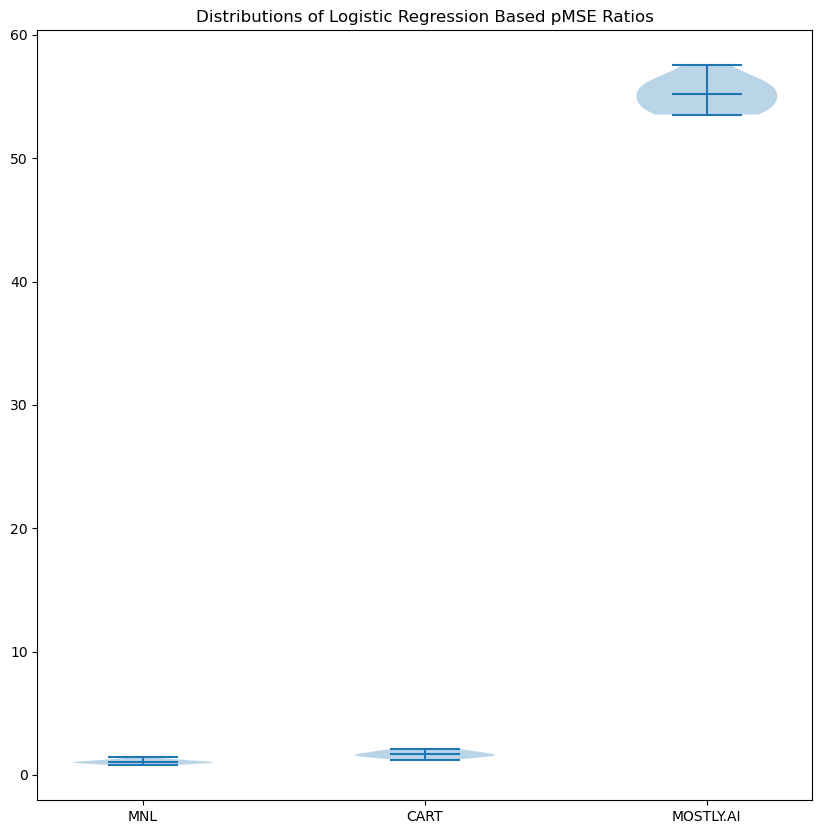

In [16]:
# Combine data
plot_data = list([ratios_mnl_pmse, ratios_cart_mb_pmse, ratios_mostly])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL", "CART", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

***

## Utility Measure 2 - Sign, Significance Match, and Overlap from Regression

Will split the data into Female and Male subsets (this was done in the original research, doing here for replicability).

Regress log of INCWAGE on years of education, third degree polynomial of potential experience, and non_white.

First we need to rescale the data using the mean and standard deviation from the confidential data.

In [17]:
stan_stats = pd.read_csv("Data/ipums_standardization_stats.csv")

In [18]:
stan_stats

,means,stds
0,24678.867448,23607.263564
1,13.116651,2.599788
2,18.481890,12.231322


## Confidence Interval Overlap

Analysis specific utility.

Use logistic regression to predict COVID-19 death based on latitude and longitude, age, and sex.

Compute the model for the original data.

In [54]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

In [165]:
def logit_param_getter(model_data):
    predictors = model_data.loc[:, ["latitude", "longitude", "sex", "age"]]
    predictors = add_constant(predictors)
    state_logit = Logit(endog=model_data.loc[:, 'state'], exog=predictors)
    logit_results = state_logit.fit()
    l_params = logit_results.params
    l_se = np.sqrt(np.diag(logit_results.cov_params()))
    return {"params": l_params, "l_se": l_se}

In [166]:
def logit_ci_getter(model_data):
    predictors = model_data.loc[:, ["latitude", "longitude", "sex", "age"]]
    predictors = add_constant(predictors)
    state_logit = Logit(endog=model_data.loc[:, 'state'], exog=predictors)
    logit_results = state_logit.fit()
    return logit_results.conf_int().reset_index(drop=True)

In [167]:
def standardized_param_diff(orig_data, synth_data):
    orig_params = logit_param_getter(orig_data)
    synth_params = logit_param_getter(synth_data)
    stan_params = [np.abs(j - synth_params['params'][i]) / orig_params['l_se'][i] for i,j in enumerate(orig_params['params'])]
    return pd.Series(stan_params)

In [168]:
synthetic_data_sets = [holdout_data, sXs_mnl_pmse, sXs_mnl_inf_pmse, sXs_cart_mb_pmse, sXs_cart_mb_inf_pmse, sXs_mostly]
median_stan_coefs = [np.median(pd.concat([standardized_param_diff(train_data, x) for x in Y], axis=1)) for Y in synthetic_data_sets]
std_stan_coefs = [np.std(pd.concat([standardized_param_diff(train_data, x) for x in Y], axis=1), ddof=1) for Y in synthetic_data_sets]

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017381
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022818
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024918
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020073
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.019085
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028316
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027717
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021483
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022761
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028543
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.036965
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.032019
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027606
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.015155
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014113
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012017
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014531
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009142
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013020
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017318
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020526
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012974
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.008979
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012718
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010007
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012238
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012922
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [169]:
median_stan_coefs

[1.321319981994244,
 0.7890566232500109,
 1.2116077340459204,
 1.2073038816128756,
 1.958321788894271,
 2.1347349090209375]

Calculate confidence interval overlap for a model applied to two data sets.

In [170]:
def interval_overlap(train_dataset, synth_dataset):
    train_ci = logit_ci_getter(train_dataset)
    synth_ci = logit_ci_getter(synth_dataset)
    
    IQ_list = []
    for i,row in train_ci.iterrows():
    
        us = synth_ci.iloc[int(i),1]
        ls = synth_ci.iloc[int(i),0]
        uo = row[1]
        lo = row[0]
    
        ui = np.min([uo, us])
    
        li = np.max([lo, ls])
    
        IQ_list.append( 0.5 * ( (ui - li)/(uo - lo) + (ui - li)/(us - ls) ) )
        
    return IQ_list

In [171]:
holdout_intervals = np.vstack([interval_overlap(train_data, x) for x in holdout_data])
mnl_pmse_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mnl_pmse])
mnl_pmse_inf_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mnl_inf_pmse])
# cart_ks_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_ks])
# cart_pmse_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_pmse])
# cart_ks_mb_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_ks])
cart_pmse_mb_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_pmse])
cart_pmse_mb_inf_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_inf_pmse])
mostly_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mostly])

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017381
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022818
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024918
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020073
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021938
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019085
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028316
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027717
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.040575
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.025068
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021861
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028787
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [174]:
np.median(holdout_intervals)

0.6329065033318173

In [175]:
np.median(mnl_pmse_intervals)

0.8127387786021227

In [176]:
np.median(mnl_pmse_inf_intervals)

0.7003984969425749

In [177]:
np.median(cart_pmse_mb_intervals)

0.6955657463755386

In [178]:
np.median(cart_pmse_mb_inf_intervals)

0.4544123579141903

In [179]:
np.median(mostly_intervals)

0.5419520181665455

In [180]:
def interval_overlap_plot(ax1, plotting_data, plot_title):
    
    xticklabels = ["Holdout", "MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
    ax1.set_xticks([1, 2, 3, 4, 5, 6])
    ax1.set_xticklabels(xticklabels)
    
    ax1.violinplot(plotting_data, showmeans=True)
    ax1.set_title(plot_title)

    ax1.set_ylabel('Interval Overlap')
    ax1.set_ylim(-1.00, 1.00)

In [181]:
# Combine data
intercept_vals = list([holdout_intervals[:,0], mnl_pmse_intervals[:,0], mnl_pmse_inf_intervals[:,0], cart_pmse_mb_intervals[:,0], cart_pmse_mb_inf_intervals[:,0], mostly_intervals[:,0]])

latitude_vals = list([holdout_intervals[:,1], mnl_pmse_intervals[:,1], mnl_pmse_inf_intervals[:,1], cart_pmse_mb_intervals[:,1], cart_pmse_mb_inf_intervals[:,1], mostly_intervals[:,1]])

longitude_vals = list([holdout_intervals[:,2], mnl_pmse_intervals[:,2], mnl_pmse_inf_intervals[:,2], cart_pmse_mb_intervals[:,2], cart_pmse_mb_inf_intervals[:,2], mostly_intervals[:,2]])

sex_vals = list([holdout_intervals[:,3], mnl_pmse_intervals[:,3], mnl_pmse_inf_intervals[:,3], cart_pmse_mb_intervals[:,3], cart_pmse_mb_inf_intervals[:,3], mostly_intervals[:,3]])

age_vals = list([holdout_intervals[:,4], mnl_pmse_intervals[:,4], mnl_pmse_inf_intervals[:,4], cart_pmse_mb_intervals[:,4], cart_pmse_mb_inf_intervals[:,4], mostly_intervals[:,4]])

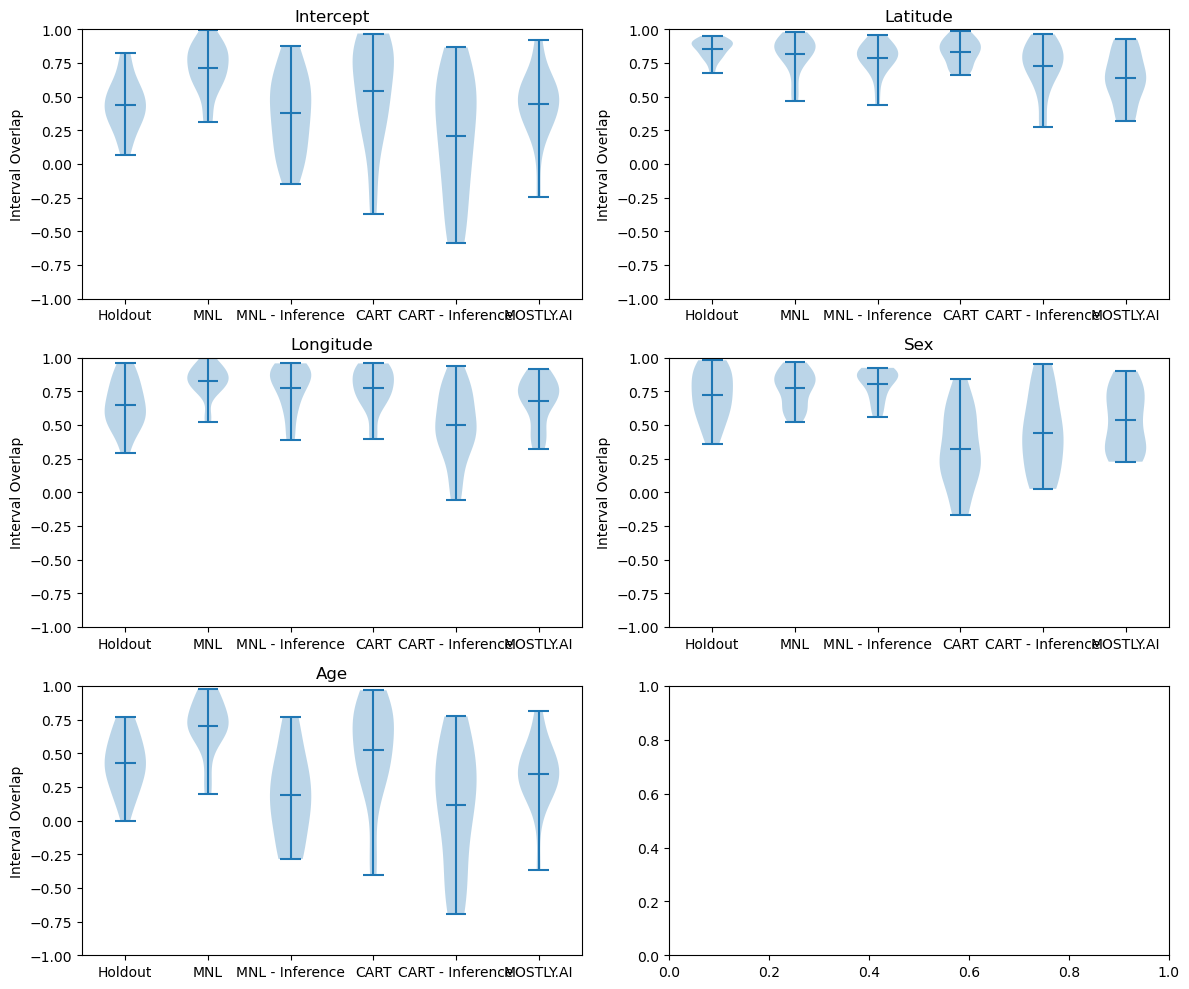

In [182]:
fig, ax = plt.subplots(3, 2, figsize=(12,10))

interval_overlap_plot(ax[0,0], intercept_vals, "Intercept")
interval_overlap_plot(ax[0,1], latitude_vals, "Latitude")
interval_overlap_plot(ax[1,0], longitude_vals, "Longitude")
interval_overlap_plot(ax[1,1], sex_vals, "Sex")
interval_overlap_plot(ax[2,0], age_vals, "Age")

plt.tight_layout()